In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Data Imputation Notebook
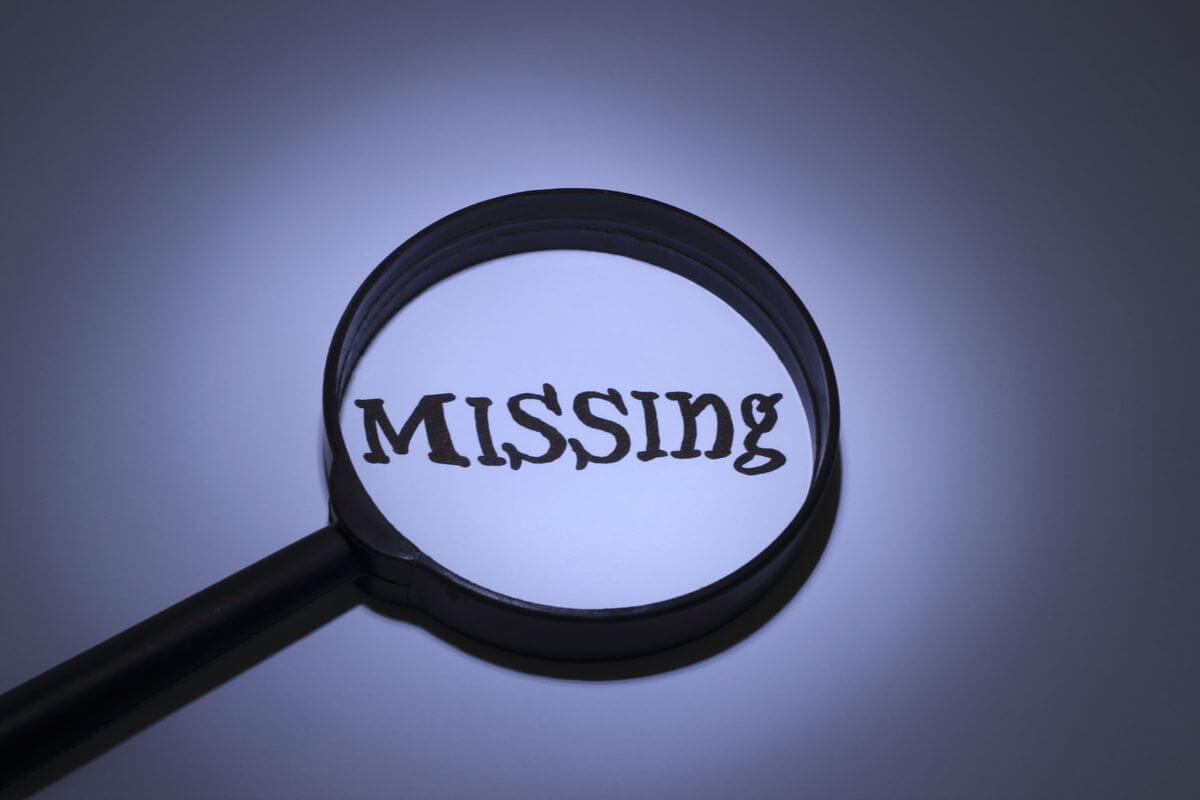!
[Do The imputation]

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
import gc
warnings.filterwarnings('ignore')

from sklearn.impute import SimpleImputer
from tqdm.notebook import tqdm
from xgboost import XGBRegressor

In [ ]:
df = pd.read_csv('../input/tabular-playground-series-jun-2022/data.csv', index_col = 'row_id')
submission = pd.read_csv('../input/tabular-playground-series-jun-2022/sample_submission.csv', index_col = 'row-col')

display(df,submission)

In [ ]:
def missing_percent(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_table = pd.concat([mis_val, mis_percent], axis=1)
        
        # Rename the columns
        mis_columns = mis_table.rename(
        columns = {0 : 'Missing Values', 1 : 'Percent of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_columns = mis_columns[
            mis_columns.iloc[:,1] != 0].sort_values(
        'Percent of Total Values', ascending=False).round(2)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_columns

In [ ]:
missing_percent(df)

In [ ]:
len(df.dropna())/len(df)

In [ ]:
features = list(df.columns)
features = features[1:len(features)]
F1_features = [feat for feat in features if feat[:3] == "F_1"]
F2_features = [feat for feat in features if feat[:3] == "F_2"]
F3_features = [feat for feat in features if feat[:3] == "F_3"]
F4_features = [feat for feat in features if feat[:3] == "F_4"]

In [ ]:
plt.figure(figsize=(15,15))
for i, f in enumerate(F1_features):
    plt.subplot(5, 5, i+1)
    axs = sns.kdeplot(x = df[f],color="#d90429")
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(15,15))
for i, f in enumerate(F2_features):
    plt.subplot(5, 5, i+1)
    axs = sns.countplot(x = df[f],palette="YlOrRd_r")
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(15,15))
for i, f in enumerate(F3_features):
    plt.subplot(5, 5, i+1)
    axs = sns.kdeplot(x = df[f],color="#d90429")
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(15,15))
for i, f in enumerate(F4_features):
    plt.subplot(5, 5, i+1)
    axs = sns.kdeplot(x = df[f],color="#d90429")
plt.tight_layout()
plt.show()

In [ ]:
df.corr()

In [ ]:
plt.figure(figsize=(11,11))
corr=df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, robust=True, center=0,square=True, linewidths=.6,cmap='YlOrRd_r')
plt.title('Correlation')
plt.show()

In [ ]:
df1 = df.copy()

**High value of missing values in the 4th column**

In [ ]:
F4_feat = [col for col in df1.columns if col.split('_')[1] == '4']
df_new = pd.DataFrame()
for feature in df1.columns:
    if feature in F4_feat:
        df_new[feature] = df1[feature]
F123_features = df1.drop(F4_feat, axis=1)

In [ ]:
feat_imp = SimpleImputer(missing_values=np.nan, strategy= 'mean')
imp = pd.DataFrame(feat_imp.fit_transform(F123_features), columns = F123_features.columns)

In [ ]:
for column in df_new.columns:
    df_train = df_new[df_new[column].isna() == False]
    df_test = df_new[df_new[column].isna() == True]
    
    X = df_train.drop(column, axis=1)
    y = df_train[column]
    
    model = XGBRegressor(random_state=123, n_estimators= 1500, booster='gbtree',verbosity = 2,tree_method = 'gpu_hist')
    model.fit(X, y)
    
    pred = model.score(X, y)
    df_new[column][df_test.index] = model.predict(df_test.drop(column, axis = 1))

In [ ]:
df3 = pd.concat([imp, df_new], axis = 1)

In [ ]:
for i in tqdm(submission.index):
    row = int(i.split('-')[0])
    col = i.split('-')[1]
    submission.loc[i, 'value'] = df3.loc[row, col]
submission.to_csv('xgb.csv')
submission

**Simple Imputer we will try first**

In [ ]:
# %%time
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer

# iterative_imputer = IterativeImputer(initial_strategy='median')
# df[:] = iterative_imputer.fit_transform(df)

[https://www.kaggle.com/code/devsubhash/tps-june-eda-xgb-simpleimputer](http://)

reference to learn from wonderfully explained !